# This notebook will generate an analog of the plot in Fig. 1 left of 2407.14460

### - Start importing all libraries

In [1]:
# Import global libs
import tqdm
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Import local libs
import fastPTA.utils as ut
import fastPTA.get_tensors as gt

### - Then set some constants to be used below

In [2]:
# Set the number of pulsars
n_pulsars = 100

# Number of realizations
n_realizations = 30

# Spherical harmonics order
l_max = 6

# Set nside (which sets the number of pixels) for healpy
nside = 12

### - A function to generate random positions for the pulsars on the sky, and compute the ORF_lm

In [3]:
def get_gamma_and_correlations(n_pulsars):
    
    # Theta and phi
    theta = np.arccos(np.random.uniform(-1, 1, n_pulsars))
    phi = np.random.uniform(0.0, 2 * np.pi, n_pulsars)

    # Generate the unit vectors
    sky_directions = gt.unit_vector(theta, phi)

    # Compute the overlap reduction function for all pulsar pairs
    correlations = gt.get_correlations_lm_IJ(sky_directions, l_max, nside)

    # Compute the inverse of the overlap reduction function for (l,m) = (0,0)
    gamma_0_inverse = np.linalg.inv(correlations[0])

    return gamma_0_inverse, correlations

### - A function to compute the uncertainties

In [4]:
def get_uncertainties(
    n_pulsars, gamma_0_inverse, correlations, autocorrelations
):

    # Use the autocorrelations if needed
    if autocorrelations:
        to_use = correlations

    else:
        to_use = jnp.where(
            (1.0 - jnp.eye(n_pulsars))[None, :, :], correlations, 0.0
        )

    # Compute the Fisher matrix
    fisher_matrix = (4 * jnp.pi) * jnp.einsum(
        "ij,kl,ajk,bli->ab",
        gamma_0_inverse,
        gamma_0_inverse,
        to_use,
        to_use,
    )

    # Compute the covariance matrix
    covariance = np.linalg.inv(fisher_matrix)

    # Return the error bars with/without correlations
    return np.sqrt(np.diag(covariance))

### - Get the errors for many realizations of the pulsar catalog

In [5]:
try:
    data = np.load('generated_data/strong_signal.npz')
    auto = data['auto']
    no_auto = data['no_auto']

except FileNotFoundError:
    # Initialize the arrays to store the uncertainties
    auto = np.zeros(shape=(n_realizations, (l_max + 1) ** 2))
    no_auto = np.zeros(shape=(n_realizations, (l_max + 1) ** 2))

    # Loop over the realizations and compute the uncertainties
    for i in tqdm.tqdm(range(n_realizations)):
        gamma, corr = get_gamma_and_correlations(n_pulsars)
        auto[i] = get_uncertainties(n_pulsars, gamma, corr, True)
        no_auto[i] = get_uncertainties(n_pulsars, gamma, corr, False)

    np.savez('generated_data/strong_signal.npz', auto=auto, no_auto=no_auto)

100%|██████████| 30/30 [11:36<00:00, 23.20s/it]


### - Plot the results

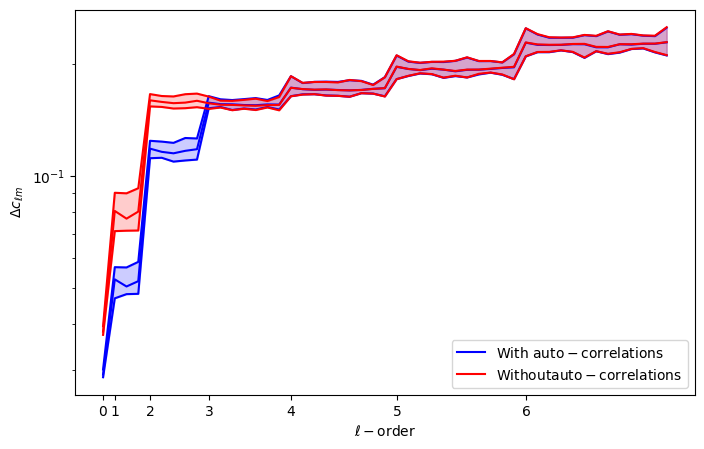

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compute the quantiles to be plotted
to_plot = np.quantile(auto, [(1 - 0.95) / 2, 0.5, (1 + 0.95) / 2], axis=0)
to_plot_no_auto = np.quantile(
    no_auto, [(1 - 0.95) / 2, 0.5, (1 + 0.95) / 2], axis=0
)

plt.figure(figsize=(8, 5))

plt.fill_between(
    np.arange(49), to_plot[0, :], to_plot[2, :], color="Blue", alpha=0.2
)

plt.plot(to_plot[0], color="Blue", label=r"${\rm With\ auto-correlations}$")
plt.plot(to_plot[1], color="Blue")
plt.plot(to_plot[2], color="Blue")

plt.fill_between(
    np.arange(49),
    to_plot_no_auto[0, :],
    to_plot_no_auto[2, :],
    color="Red",
    alpha=0.2,
)

plt.plot(
    to_plot_no_auto[0], color="Red", label=r"${\rm Without auto-correlations}$"
)
plt.plot(to_plot_no_auto[1], color="Red")
plt.plot(to_plot_no_auto[2], color="Red")

custom_xticks = [0] +[ut.get_n_coefficients_real(i) for i in range(0, l_max )]
custom_xtick_labels = [r"$0$", r"$1$", r"$2$", r"$3$", r"$4$", r"$5$", r"$6$"]
plt.xticks(custom_xticks, custom_xtick_labels)

plt.xlabel(r"$\ell - {\rm order}$")
plt.ylabel(r"$\Delta{c_{\ell m}}$")
plt.yscale("log")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("plots/strong_signal.pdf")
plt.show();